In [12]:
library('tidyverse')
library("hise")
library('data.table')
library('parallel')
library('dplyr')
library(patchwork)
library(ggplot2)
library(arrow)
set.seed(123)

Sys.setenv( TZ="Etc/GMT+1")
options(warn = -1)

In [2]:
pesudo_time_df<-as.data.frame(read_parquet('pesudo_time_df.csv'))
pesudo_time_df<-pesudo_time_df[!is.na(pesudo_time_df$AIFI_L3),]
pesudo_time_df <- pesudo_time_df %>%
  mutate(cohort.x = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "BR2",
    TRUE ~ 'UP1' 
  ))

ERROR: Error in read_parquet("pesudo_time_df.csv"): could not find function "read_parquet"


In [1]:
pesudo_time_df

ERROR: Error: object 'pesudo_time_df' not found


# pesudo_time 2

## Th2

In [4]:
patterns <- c("GATA3", "STAT6", "STAT5A", "STAT5B", "IRF4", "NFATC1","TBX21")

matched_cols <- unlist(lapply(patterns, function(p) {
  colnames(pesudo_time_df)[grepl(p, colnames(pesudo_time_df))]
}))

matched_cols


ERROR: Error in FUN(X[[i]], ...): object 'pesudo_time_df' not found


In [15]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("2",curve.assignments))

In [16]:
p_list <- list()
for (i in matched_cols) {
  
  p <- ggplot(subset_data, aes(pesudo_time_2, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A  
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <- ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, color = "black") +
  labs(
    y = NULL,  
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_linedraw() +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(),
    axis.title.y.right = element_text(size = 10, angle = 90), 
    axis.text.y.right = element_blank(), 
    axis.ticks.y.right = element_blank() 
  ) +
  scale_y_continuous(limits = c(-0.3, 0.3),
    sec.axis = sec_axis(~., name = str_extract(i, "(?<=_)[^_]+(?=_)"))
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


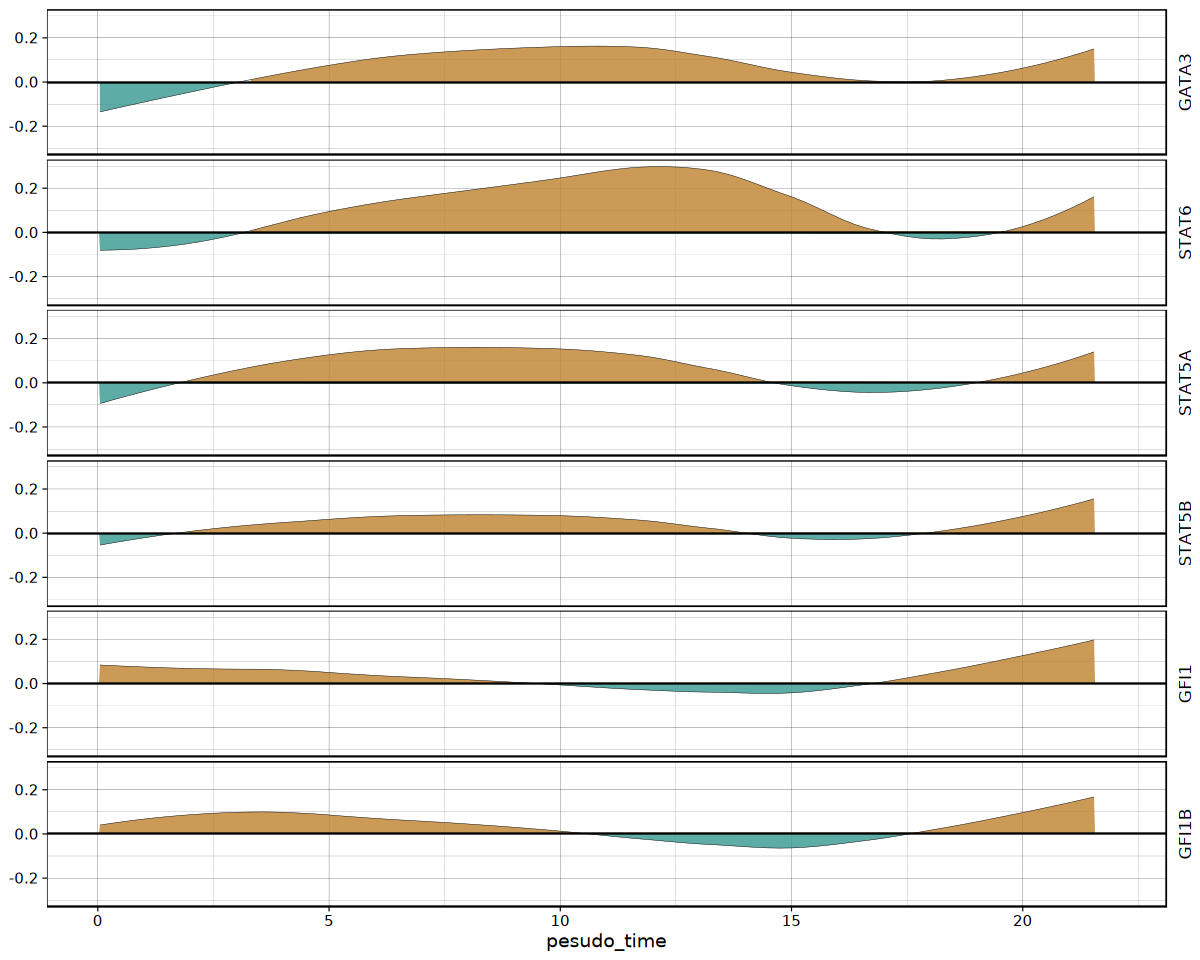

In [17]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")
p_combined

In [18]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_2, 0.95),
  min_range = quantile(pesudo_time_2, 0.05)
)

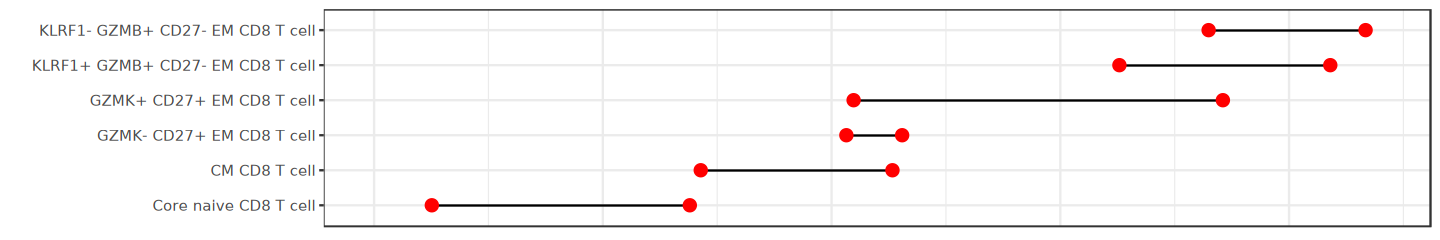

In [19]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(celltype_new = fct_reorder(AIFI_L3, min_range)), 
  aes(x = celltype_new)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)
p1

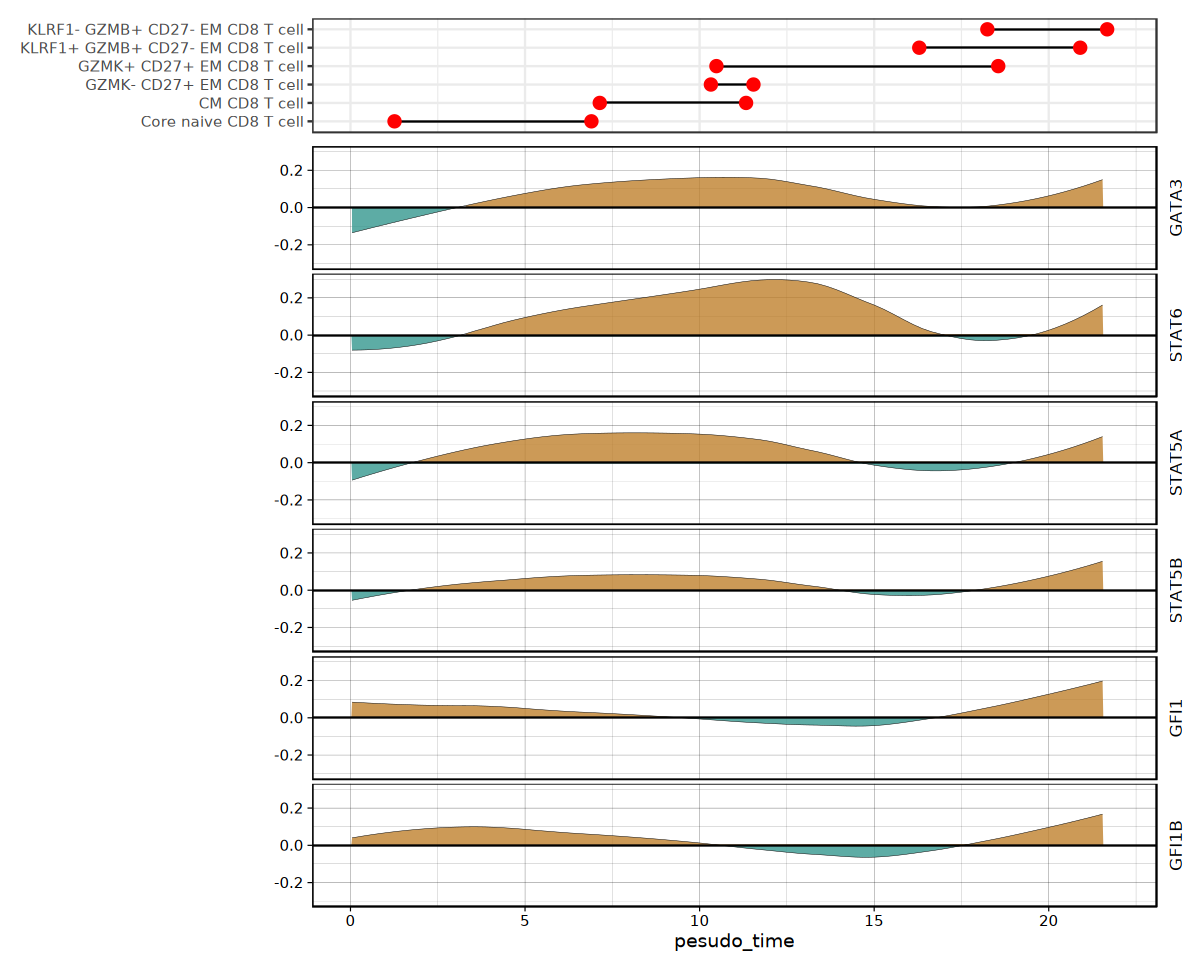

In [20]:
options(repr.plot.width = 10, repr.plot.height =8)

p1 / p_combined+ plot_layout(heights = c(0.15, 1))


## All Others

In [21]:
patterns <- c("IRF4","SPI1","TBX21","STAT1","STAT4",
              "EOME","RUNX3","RAR","RORC","STAT3" ,"AHR_" ,"HIF1" ,"FOXP3","SMAD2","SMAD3","BCL6_" ,"BATF_","TCF7_","LEF1","FOXP1")

matched_cols <- unlist(lapply(patterns, function(p) {
  colnames(pesudo_time_df)[grepl(p, colnames(pesudo_time_df))]
}))

matched_cols

[1] "motif_IRF4_632"  "motif_SPI1_322"  "motif_TBX21_780" "motif_STAT1_773"
 [5] "motif_STAT4_775" "motif_EOMES_788" "motif_RUNX3_731" "motif_RARB_659" 
 [9] "motif_RARA_675"  "motif_RARG_690"  "motif_RORC_681"  "motif_STAT3_777"
[13] "motif_AHR_28"    "motif_HIF1A_24"  "motif_FOXP3_348" "motif_SMAD2_745"
[17] "motif_SMAD3_743" "motif_BCL6_187"  "motif_BATF_129"  "motif_TCF7_750" 
[21] "motif_LEF1_760"  "motif_FOXP1_353"

In [22]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("2",curve.assignments))

In [23]:
p_list <- list()
for (i in matched_cols) {
  
  p <- ggplot(subset_data, aes(pesudo_time_2, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A  
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <- ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, color = "black") +
  labs(
    y = NULL,  
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_linedraw() +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(),
    axis.title.y.right = element_text(size = 10, angle = 90), 
    axis.text.y.right = element_blank(), 
    axis.ticks.y.right = element_blank() 
  ) +
  scale_y_continuous(limits = c(-0.5, 0.5),
    sec.axis = sec_axis(~., name = str_extract(i, "(?<=_)[^_]+(?=_)"))
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


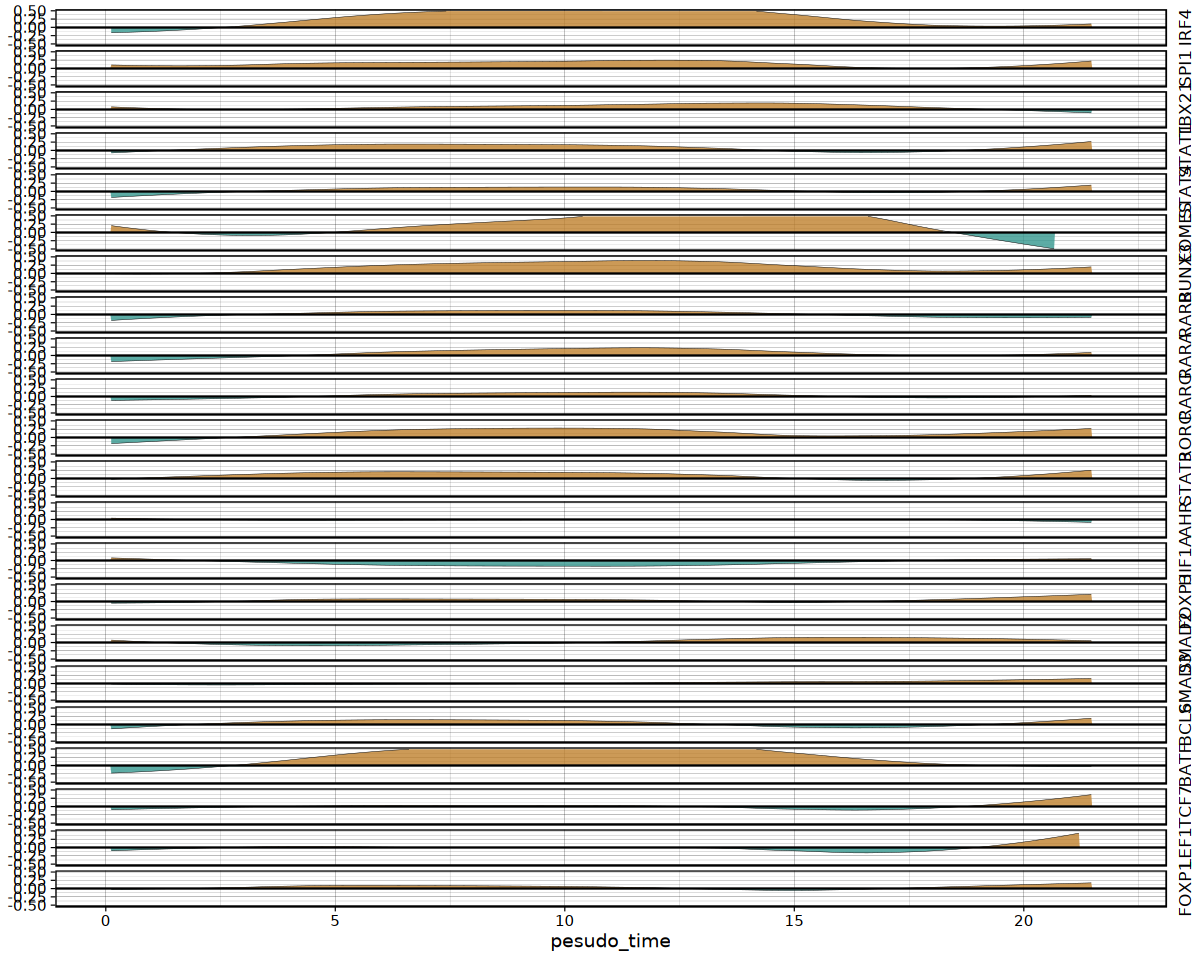

In [24]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")
p_combined

In [25]:
summary_range<-subset_data%>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_2, 0.95),
  min_range = quantile(pesudo_time_2, 0.05)
)

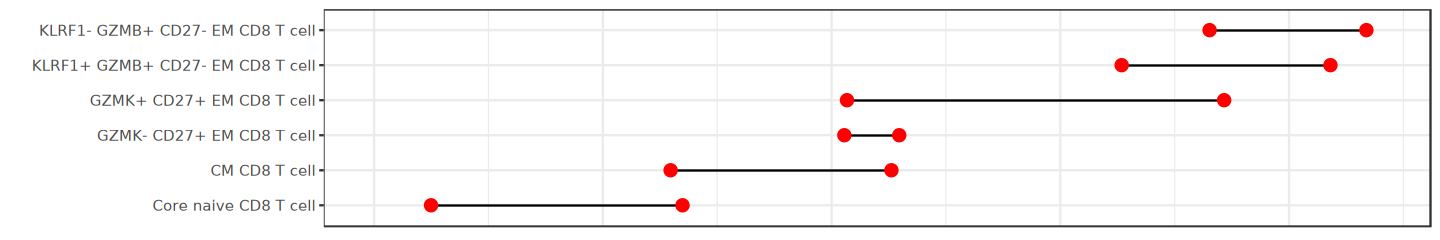

In [26]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(celltype_new = fct_reorder(AIFI_L3, min_range)), 
  aes(x = celltype_new)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)
p1

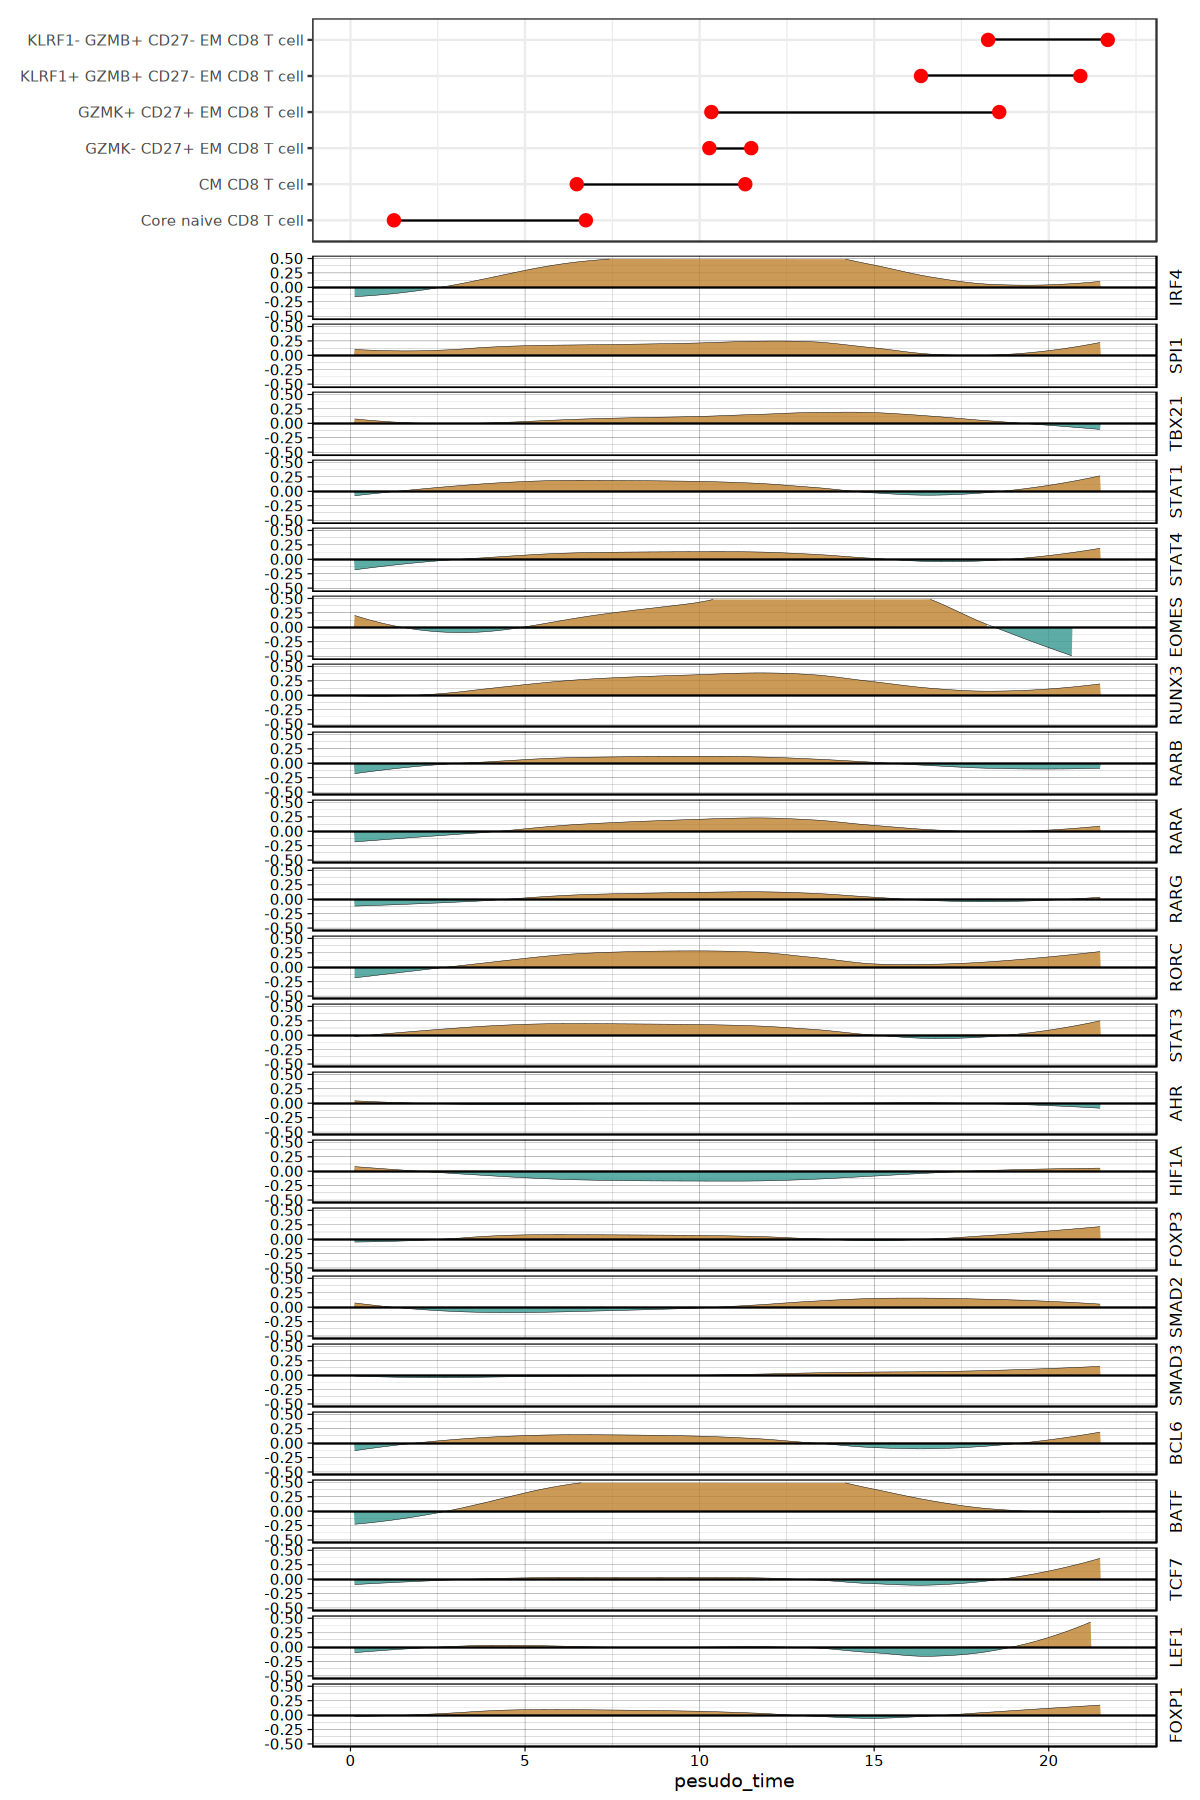

In [27]:
options(repr.plot.width = 10, repr.plot.height =15)

p1 / p_combined+ plot_layout(heights = c(0.15, 1))


# pesudo_time 1

## Th2

In [28]:
patterns <- c("GATA3", "STAT6", "STAT5A", "STAT5B", "GFI")#,"IRF4","SPI1")

matched_cols <- unlist(lapply(patterns, function(p) {
  colnames(pesudo_time_df)[grepl(p, colnames(pesudo_time_df))]
}))

matched_cols


[1] "motif_GATA3_384"  "motif_STAT6_776"  "motif_STAT5A_774" "motif_STAT5B_779"
[5] "motif_GFI1_220"   "motif_GFI1B_228"

In [29]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]   %>% filter(grepl("1",curve.assignments))

In [30]:
p_list <- list()
for (i in matched_cols) {
  
  p <- ggplot(subset_data, aes(pesudo_time_1, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <- ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, color = "black") +
  labs(
    y = NULL,  
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_linedraw() +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(),
    axis.title.y.right = element_text(size = 10, angle = 90), 
    axis.text.y.right = element_blank(), 
    axis.ticks.y.right = element_blank() 
  ) +
  scale_y_continuous(limits = c(-0.3, 0.3),
    sec.axis = sec_axis(~., name = str_extract(i, "(?<=_)[^_]+(?=_)"))
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 21)

}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In [31]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")


In [32]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

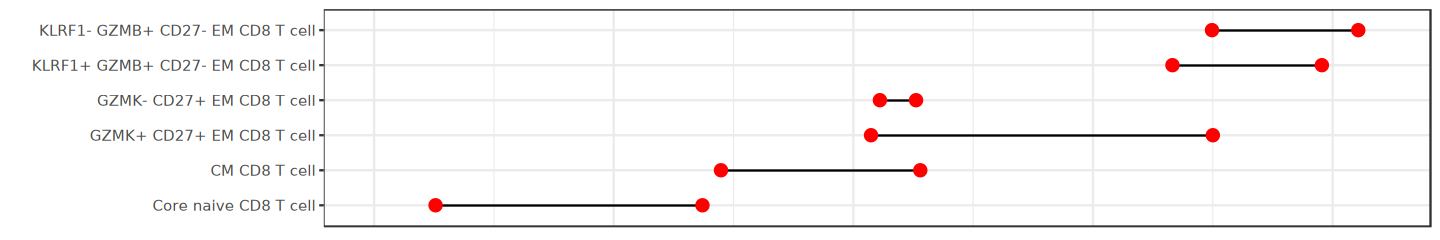

In [33]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(celltype_new = fct_reorder(AIFI_L3, min_range)), 
  aes(x = celltype_new)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,21)
p1

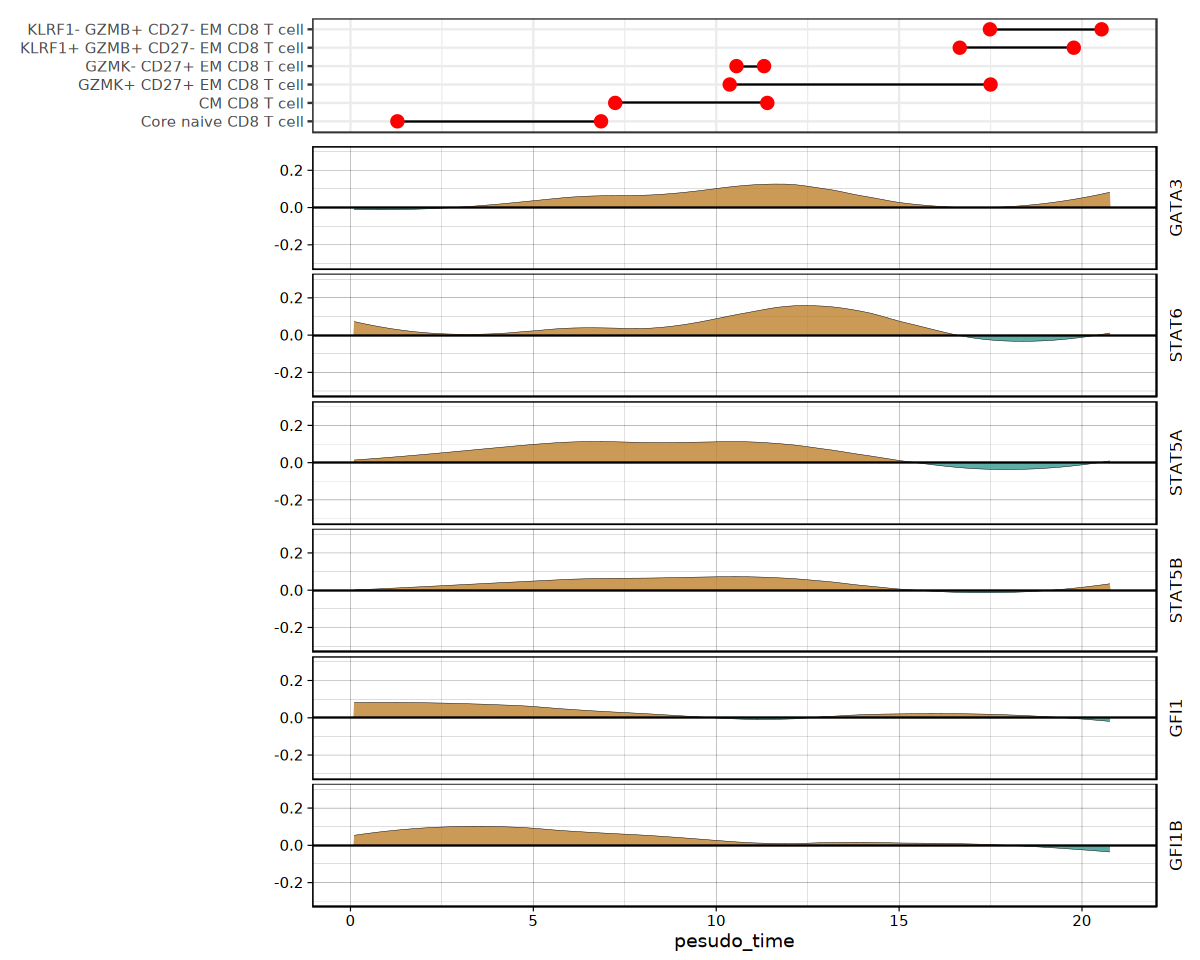

In [34]:
options(repr.plot.width = 10, repr.plot.height =8)

p1 / p_combined+ plot_layout(heights = c(0.15, 1))


## All Others

In [35]:
patterns <- c("IRF4","SPI1","TBX21","STAT1","STAT4","EOME","RUNX3","RAR","RORC","STAT3" ,"AHR_" ,"HIF1" ,"FOXP3","SMAD2","SMAD3","BCL6_" ,"BATF_","TCF7_","LEF1","FOXP1")

matched_cols <- unlist(lapply(patterns, function(p) {
  colnames(pesudo_time_df)[grepl(p, colnames(pesudo_time_df))]
}))

matched_cols

[1] "motif_IRF4_632"  "motif_SPI1_322"  "motif_TBX21_780" "motif_STAT1_773"
 [5] "motif_STAT4_775" "motif_EOMES_788" "motif_RUNX3_731" "motif_RARB_659" 
 [9] "motif_RARA_675"  "motif_RARG_690"  "motif_RORC_681"  "motif_STAT3_777"
[13] "motif_AHR_28"    "motif_HIF1A_24"  "motif_FOXP3_348" "motif_SMAD2_745"
[17] "motif_SMAD3_743" "motif_BCL6_187"  "motif_BATF_129"  "motif_TCF7_750" 
[21] "motif_LEF1_760"  "motif_FOXP1_353"

In [36]:
table(subset_data$AIFI_L3)


                   CM CD8 T cell            Core naive CD8 T cell 
                             259                             3210 
       GZMK+ CD27+ EM CD8 T cell        GZMK- CD27+ EM CD8 T cell 
                            1793                                9 
KLRF1+ GZMB+ CD27- EM CD8 T cell KLRF1- GZMB+ CD27- EM CD8 T cell 
                             586                              217 

In [37]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("1",curve.assignments))

In [38]:
p_list <- list()
for (i in matched_cols) {
  
  p <- ggplot(subset_data, aes(pesudo_time_1, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  # Check if the current element is the last one
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <- ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, color = "black") +
  labs(
    y = NULL,  # Remove the left y-axis title
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_linedraw() +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(), # Remove title from the left
    axis.title.y.right = element_text(size = 10, angle = 90), # Add title to the right
    axis.text.y.right = element_blank(), # Remove text on the right
    axis.ticks.y.right = element_blank() # Remove ticks on the right
  ) +
  scale_y_continuous(limits = c(-0.5, 0.5),
    sec.axis = sec_axis(~., name = str_extract(i, "(?<=_)[^_]+(?=_)"))
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) + 

  xlim(0, 21)
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


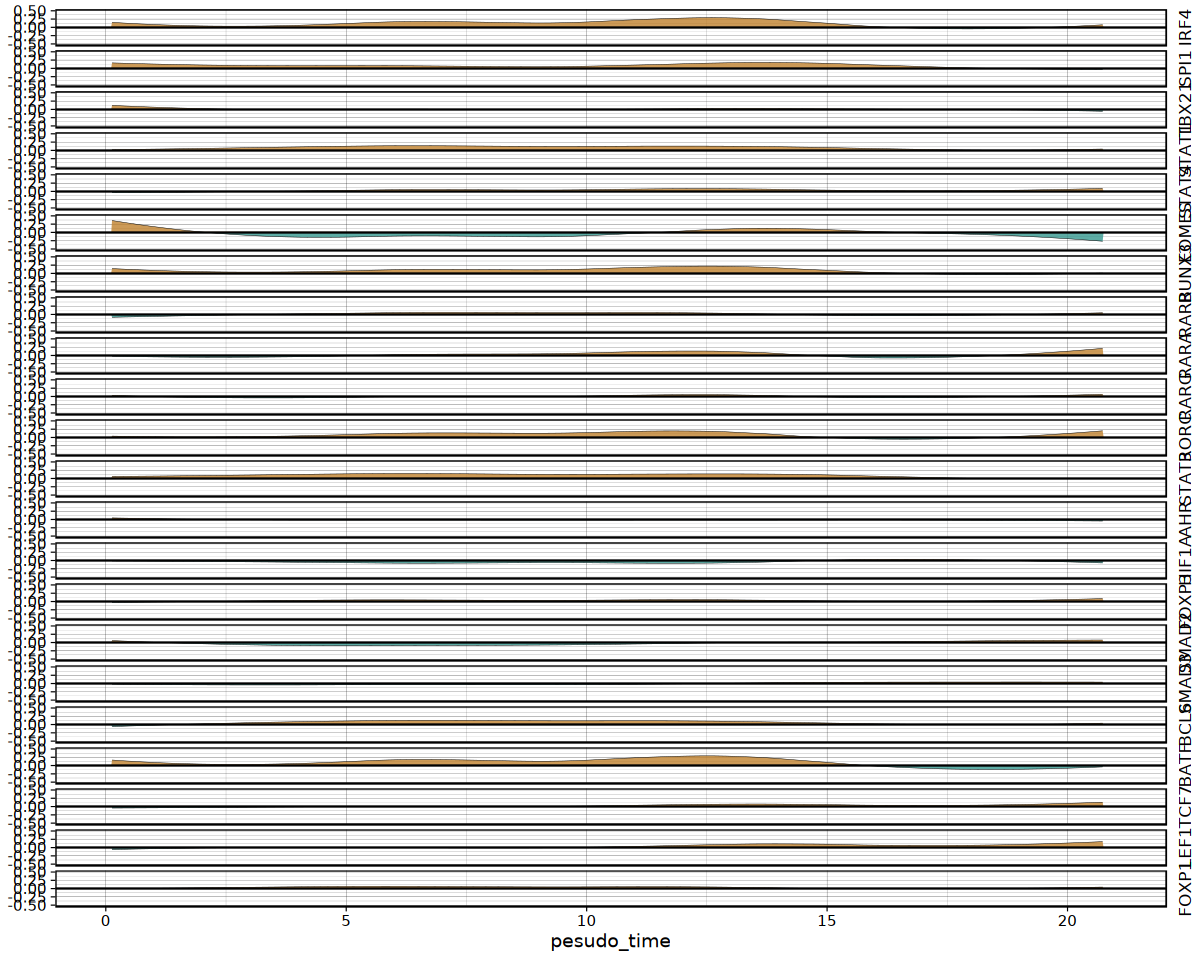

In [39]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")
p_combined

In [40]:
summary_range<-subset_data%>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

In [41]:
summary_range

AIFI_L3,max_range,min_range
<chr>,<dbl>,<dbl>
CM CD8 T cell,11.528107,5.731710
Core naive CD8 T cell,6.743527,1.179312
GZMK+ CD27+ EM CD8 T cell,17.442463,10.441763
GZMK- CD27+ EM CD8 T cell,11.334948,10.627379
KLRF1+ GZMB+ CD27- EM CD8 T cell,19.750330,16.535414
KLRF1- GZMB+ CD27- EM CD8 T cell,20.495978,17.396656


In [42]:
options(repr.plot.width = 12, repr.plot.height =2)


p1 <- ggplot(
  summary_range %>% 
    mutate(celltype_new = fct_reorder(AIFI_L3, min_range)), 
  aes(x = celltype_new)
) +  
  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip() + 
  xlab("") + ylab("") +
  theme(
    axis.title.x = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank()
  ) + 
  scale_y_continuous(limits = c(0, 21))  

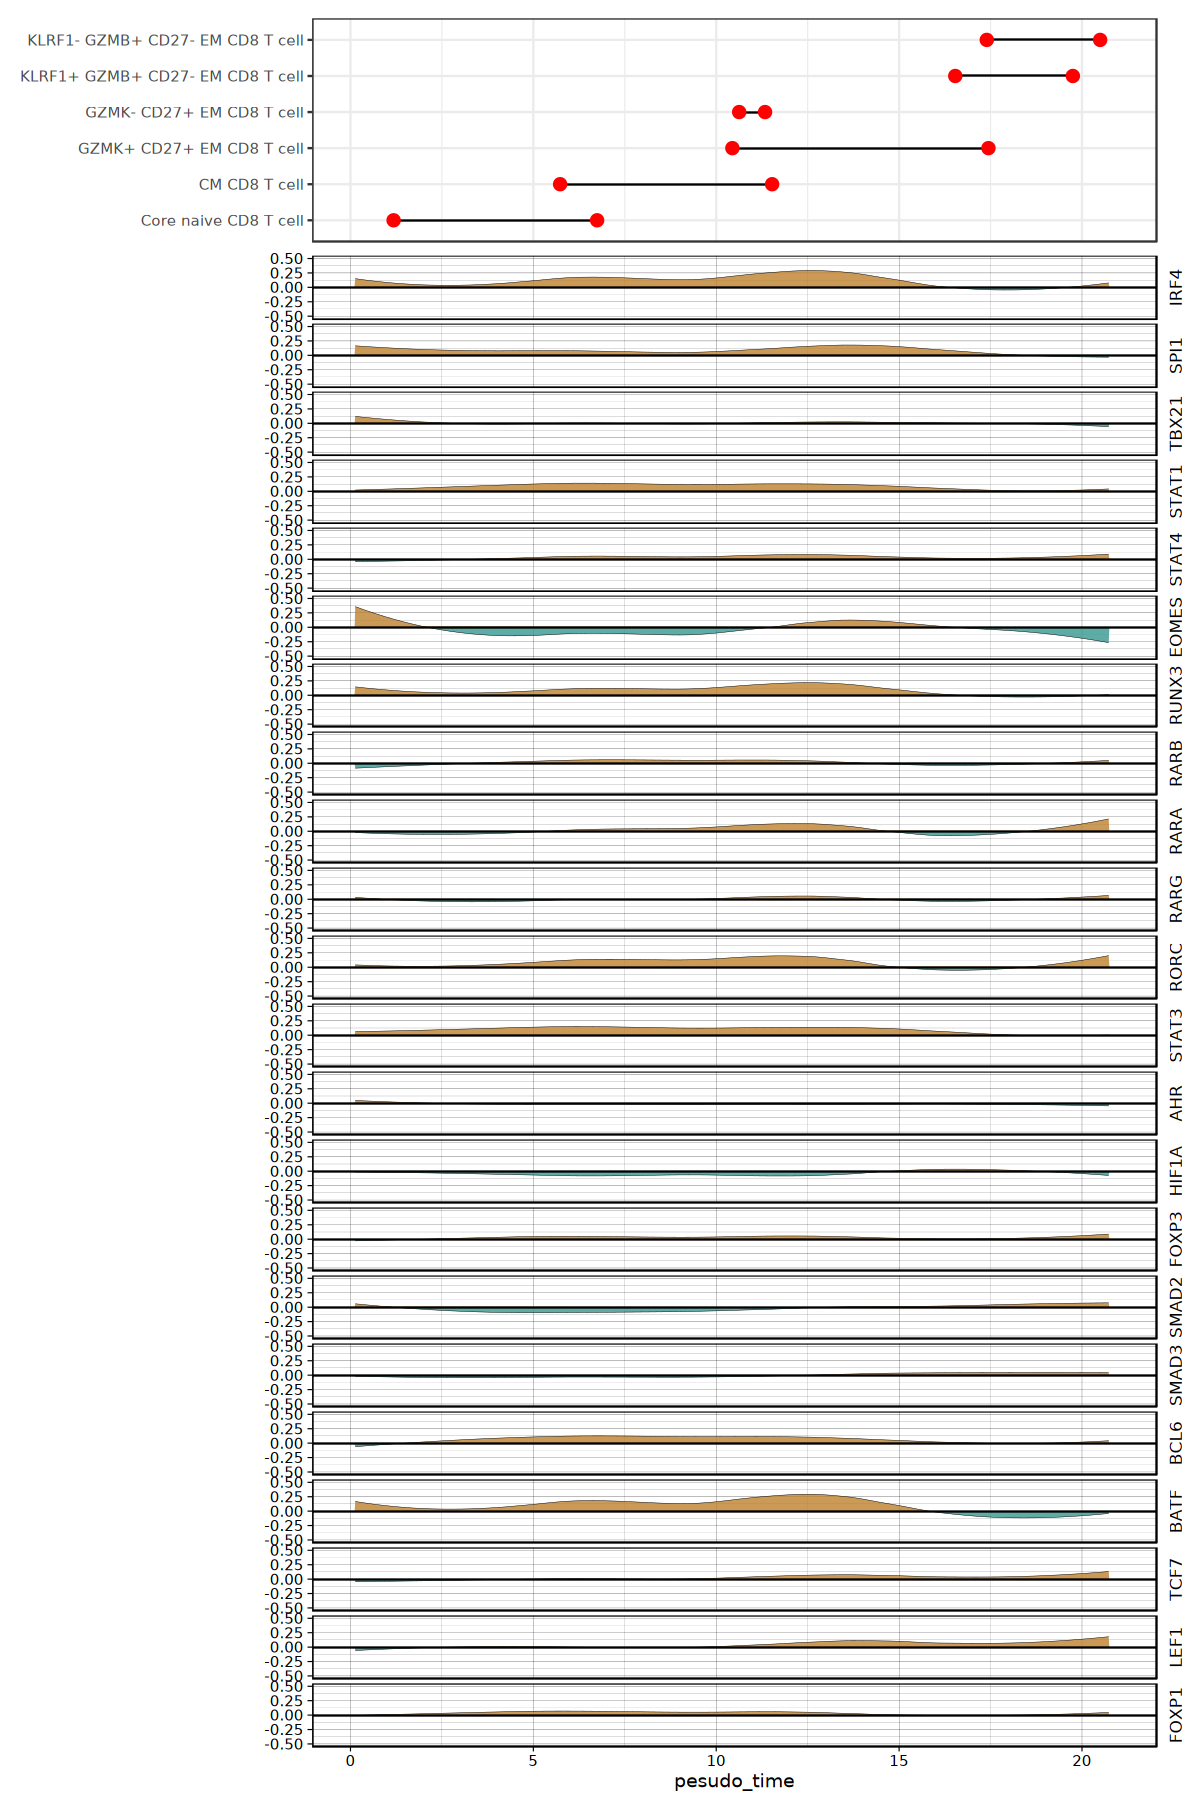

In [43]:
options(repr.plot.width = 10, repr.plot.height =15)

p1 / p_combined+ plot_layout(heights = c(0.15, 1))
